In [1]:
!pip install tqdm seaborn

In [2]:
from tensorflow.keras.layers import (
    Conv1D,
    Conv2D,
    MaxPooling1D,
    MaxPooling2D,
    Dense,
    GlobalMaxPooling1D,
    Flatten,
    Dropout,
    Input,
    BatchNormalization,
)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix
from random import sample, seed, shuffle
from datetime import datetime
from tqdm import tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np

import mlflow
import pickle
import time
import os


mlflow.set_tracking_uri("http://mlflow:5000")
mlflow.set_experiment("bolsa_pacientes")

#################### CONFIGURACIÓN #####################

BATCH_SIZE = 2
NUM_CLASES = 3

# configuración de semilla de random
seed = 42

# configuración de plots
plt.style.use("ggplot")
plt.rcParams['figure.dpi'] = 200

# paths
ventanas_path = "../data/windows_per_csv"
ventanas_csv = os.listdir(ventanas_path)

# ------------------------------------------------------

#################### FUNCIONES #####################
def cargar_en_ram(archivos):
  datos = []

  for archivo in tqdm(archivos):
    ventana = pd.read_parquet(os.path.join(ventanas_path, archivo))

    if archivo.split("_")[2] == "prepreictal":
      label = 0
    elif archivo.split("_")[2] == "preictal":
      label = 1
    elif archivo.split("_")[2] == "interictal":
      label = 2

    ventana = np.array(ventana)
    labels_onehot = tf.keras.utils.to_categorical(label, num_classes=3)

    datos.append((np.array(ventana), labels_onehot))

  return datos

def cargar_ventanas(paciente: str) -> tuple:
  """Carga las 4 listas por paciente.

  Devuelve prepre, pre, ictal e inter.
  """
  ventanas = [ven for ven in ventanas_csv if ven.startswith(paciente)]
  prepre = [ven for ven in ventanas if ven.split("_")[2] == "prepreictal"]
  pre = [ven for ven in ventanas if ven.split("_")[2] == "preictal"]
  ictal = [ven for ven in ventanas if ven.split("_")[2] == "ictal"]
  inter = [ven for ven in ventanas if ven.split("_")[2] == "interictal"]
  return prepre, pre, ictal, inter


def cargar_ventanas_pacientes(lista_pacientes: list[str]) -> tuple[list]:
  """Carga las ventanas de distintos pacientes y devuelve una tupla de 4
  listas donde están las ventanas de todos los pacientes elegidos (mezclados)
  """
  prepre_pacientes = []
  pre_pacientes = []
  ictal_pacientes = []
  inter_pacientes = []

  for paciente in lista_pacientes:
    prepre, pre, ictal, inter = cargar_ventanas(paciente)

    prepre_pacientes.extend(prepre)
    pre_pacientes.extend(pre)
    ictal_pacientes.extend(ictal)
    inter_pacientes.extend(inter)

  return prepre_pacientes, pre_pacientes, ictal_pacientes, inter_pacientes


def archivos_train_test_split(archivos: list[str], test_size: float = 0.2, random_state: int = seed):
  """Archivos es una lista de paths. Devuelve dos listas de paths spliteadas"""
  seed = random_state
  cantidad_test = int(test_size*len(archivos))
  test = sample(archivos, cantidad_test)
  train = [a for a in archivos if a not in test]
  return train, test


def data_generator(archivos, batch_size, debug=False, barra_tqdm=False, path_raw=ventanas_path):
    """Generador para cargar datos en batches"""
    #########################################
    # Se ignora la clase de ictal
    #########################################

    while True:
        if barra_tqdm:
          rango = tqdm(range(0, len(archivos), batch_size), desc="Cargando batches")
        else:
          rango = range(0, len(archivos), batch_size)
        for i in rango:
            batch_files = archivos[i:i+batch_size]
            batch_data = [
                pd.read_csv(os.path.join(path_raw, archivo)).values for archivo in batch_files
            ]
            # NO TOMO LOS ARCHIVOS DE ICTAL
            batch_labels = [int(archivo.split("_")[2] == "prepreictal") +
                            2*int(archivo.split("_")[2] == "preictal") +
                            # 3*int(archivo.split("_")[2] == "ictal") +
                            # 4*int(archivo.split("_")[2] == "interictal") -
                            3*int(archivo.split("_")[2] == "interictal") -
                            1 for archivo in batch_files]

            # 0: prepre, 1: pre, 2: ict, 3: inter
            if debug:
                print(f"Procesando archivos desde {i} hasta {i+batch_size}")
                print(f"Dimensiones de batch_data: {np.array(batch_data).shape}")
                print(f"Dimensiones de batch_labels: {np.array(batch_labels).shape}")
                print(f"Primer elemento de batch_labels: {batch_labels[0]}")

            batch_labels = np.array(batch_labels)
            labels_onehot = tf.keras.utils.to_categorical(batch_labels, num_classes=NUM_CLASES)

            yield np.array(batch_data), labels_onehot

2024-07-14 08:00:45.846745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 08:00:45.938028: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 08:00:45.965861: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-14 08:00:46.127521: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
lista_pacientes = [
    "chb01",
    "chb02",
    "chb03",
    "chb04",
    "chb05",
    "chb06",
    "chb07",
    "chb08",
    "chb09",
    "chb10",
    "chb11",
    "chb12",
    "chb13",
    "chb14",
    "chb15",
]


prepre, pre, ictal, inter = cargar_ventanas_pacientes(
    lista_pacientes
)

print("Largos de (prepre, pre, ictal, inter)")
print(len(prepre), len(pre), len(ictal), len(inter))

# tomo solo N ventanas de inter
print(f"Tomo {len(pre)} ventanas de ictal.")
inter = sample(inter, len(pre))

train_prepre, test_prepre = archivos_train_test_split(prepre)

train_pre, test_pre = archivos_train_test_split(pre)

# train_ictal, test_ictal = archivos_train_test_split(ictal)
# train_ictal, val_ictal = archivos_train_test_split(train_ictal)

train_inter, test_inter = archivos_train_test_split(inter)

train_files = train_prepre + train_pre + train_inter
test_files = test_prepre + test_pre + test_inter

shuffle(train_files) # es inplace

train = cargar_en_ram(train_files)
prueba = cargar_en_ram(test_files)


Largos de (prepre, pre, ictal, inter)
378 450 91 1695
Tomo 450 ventanas de ictal.


100%|██████████| 255/255 [00:04<00:00, 58.83it/s]


# Modelos

In [4]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Reshape

def create_model_mlp():
    model = Sequential()
    model.add(Flatten(input_shape=(15360, 22)))
    model.add(BatchNormalization())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(3, activation="softmax"))
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=["accuracy"]
    )

    return model

def create_model_cnn1D():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=256, activation='relu', input_shape=(15360, 22)))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Conv1D(filters=16, kernel_size=64, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(3, activation="softmax"))
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=["accuracy"]
    )

    return model

def create_model_cnn2D():
    model = Sequential()
    model.add(Reshape((15360, 22, 1), input_shape=(15360, 22)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(3, activation="softmax"))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=["accuracy"]
    )

    return model

def create_parallel_cnn1D():
    # Definir las entradas para cada banda de frecuencia
    inputs = Input(shape=(15360, 22))

    # Capas de convolución para cada banda de frecuencia
    conv_theta = Conv1D(filters=64, kernel_size=256, activation='relu')(inputs)
    conv_alpha = Conv1D(filters=64, kernel_size=64, activation='relu')(inputs)
    conv_beta = Conv1D(filters=64, kernel_size=16, activation='relu')(inputs)
    conv_gamma = Conv1D(filters=64, kernel_size=8, activation='relu')(inputs)
    conv_delta = Conv1D(filters=64, kernel_size=4, activation='relu')(inputs)

    # Capas de pooling para cada banda de frecuencia
    pool_theta = MaxPooling1D(pool_size=4)(conv_theta)
    pool_alpha = MaxPooling1D(pool_size=4)(conv_alpha)
    pool_beta = MaxPooling1D(pool_size=4)(conv_beta)
    pool_gamma = MaxPooling1D(pool_size=4)(conv_gamma)
    pool_delta = MaxPooling1D(pool_size=4)(conv_delta)

    # Aplanar las salidas
    flat_theta = Flatten()(pool_theta)
    flat_alpha = Flatten()(pool_alpha)
    flat_beta = Flatten()(pool_beta)
    flat_gamma = Flatten()(pool_gamma)
    flat_delta = Flatten()(pool_delta)

    # Fusionar las salidas de las capas de convolución
    merged = tf.keras.layers.concatenate([flat_theta, flat_alpha, flat_beta, flat_gamma, flat_delta])

    # Resto del modelo (normalización, capas completamente conectadas, etc.)
    merged = BatchNormalization()(merged)
    merged = Dense(128, activation="relu")(merged)
    merged = Dropout(0.1)(merged)
    merged = Dense(32, activation="relu")(merged)
    output = Dense(3, activation="softmax")(merged)

    # Crear el modelo
    model = Model(inputs=inputs, outputs=output)

    # Compilar el modelo
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=["accuracy"]
    )

    return model


def create_parallel_cnn2D():
    inputs = Input(shape=(15360, 22, 1))

    # Capas de convolución para cada banda de frecuencia
    conv_theta = Conv2D(filters=64, kernel_size=(256, 22), padding="valid", activation='relu', )(inputs)
    conv_alpha = Conv2D(filters=64, kernel_size=(64, 22), padding="valid", activation='relu')(inputs)
    conv_beta = Conv2D(filters=64, kernel_size=(16, 22), padding="valid", activation='relu')(inputs)
    conv_gamma = Conv2D(filters=64, kernel_size=(8, 22), padding="valid", activation='relu')(inputs)
    conv_delta = Conv2D(filters=64, kernel_size=(4, 22), padding="valid", activation='relu')(inputs)

    # Capas de pooling para cada banda de frecuencia
    pool_theta = MaxPooling2D(pool_size=(1, 2))(conv_theta)
    pool_alpha = MaxPooling2D(pool_size=(1, 2))(conv_alpha)
    pool_beta = MaxPooling2D(pool_size=(1, 2))(conv_beta)
    pool_gamma = MaxPooling2D(pool_size=(1, 2))(conv_gamma)
    pool_delta = MaxPooling2D(pool_size=(1, 2))(conv_delta)

    # Aplanar las salidas
    flat_theta = Flatten()(pool_theta)
    flat_alpha = Flatten()(pool_alpha)
    flat_beta = Flatten()(pool_beta)
    flat_gamma = Flatten()(pool_gamma)
    flat_delta = Flatten()(pool_delta)

    # Fusionar las salidas de las capas de convolución
    merged = tf.keras.layers.concatenate([flat_theta, flat_alpha, flat_beta, flat_gamma, flat_delta])

    # Resto del modelo (normalización, capas completamente conectadas, etc.)
    merged = BatchNormalization()(merged)
    merged = Dense(128, activation="relu")(merged)
    merged = Dropout(0.1)(merged)
    merged = Dense(32, activation="relu")(merged)
    output = Dense(3, activation="softmax")(merged)

    # Crear el modelo
    model = Model(inputs=inputs, outputs=output)

    # Compilar el modelo
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=["accuracy"]
    )

    return model

##########################################################

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.99:
            print("\nPrecisión alcanzada al 99%, deteniendo el entrenamiento.")
            self.model.stop_training = True

In [5]:
X = np.array([t[0] for t in train])
y = np.array([t[1] for t in train])

In [6]:
y[2]

array([0., 0., 1.])

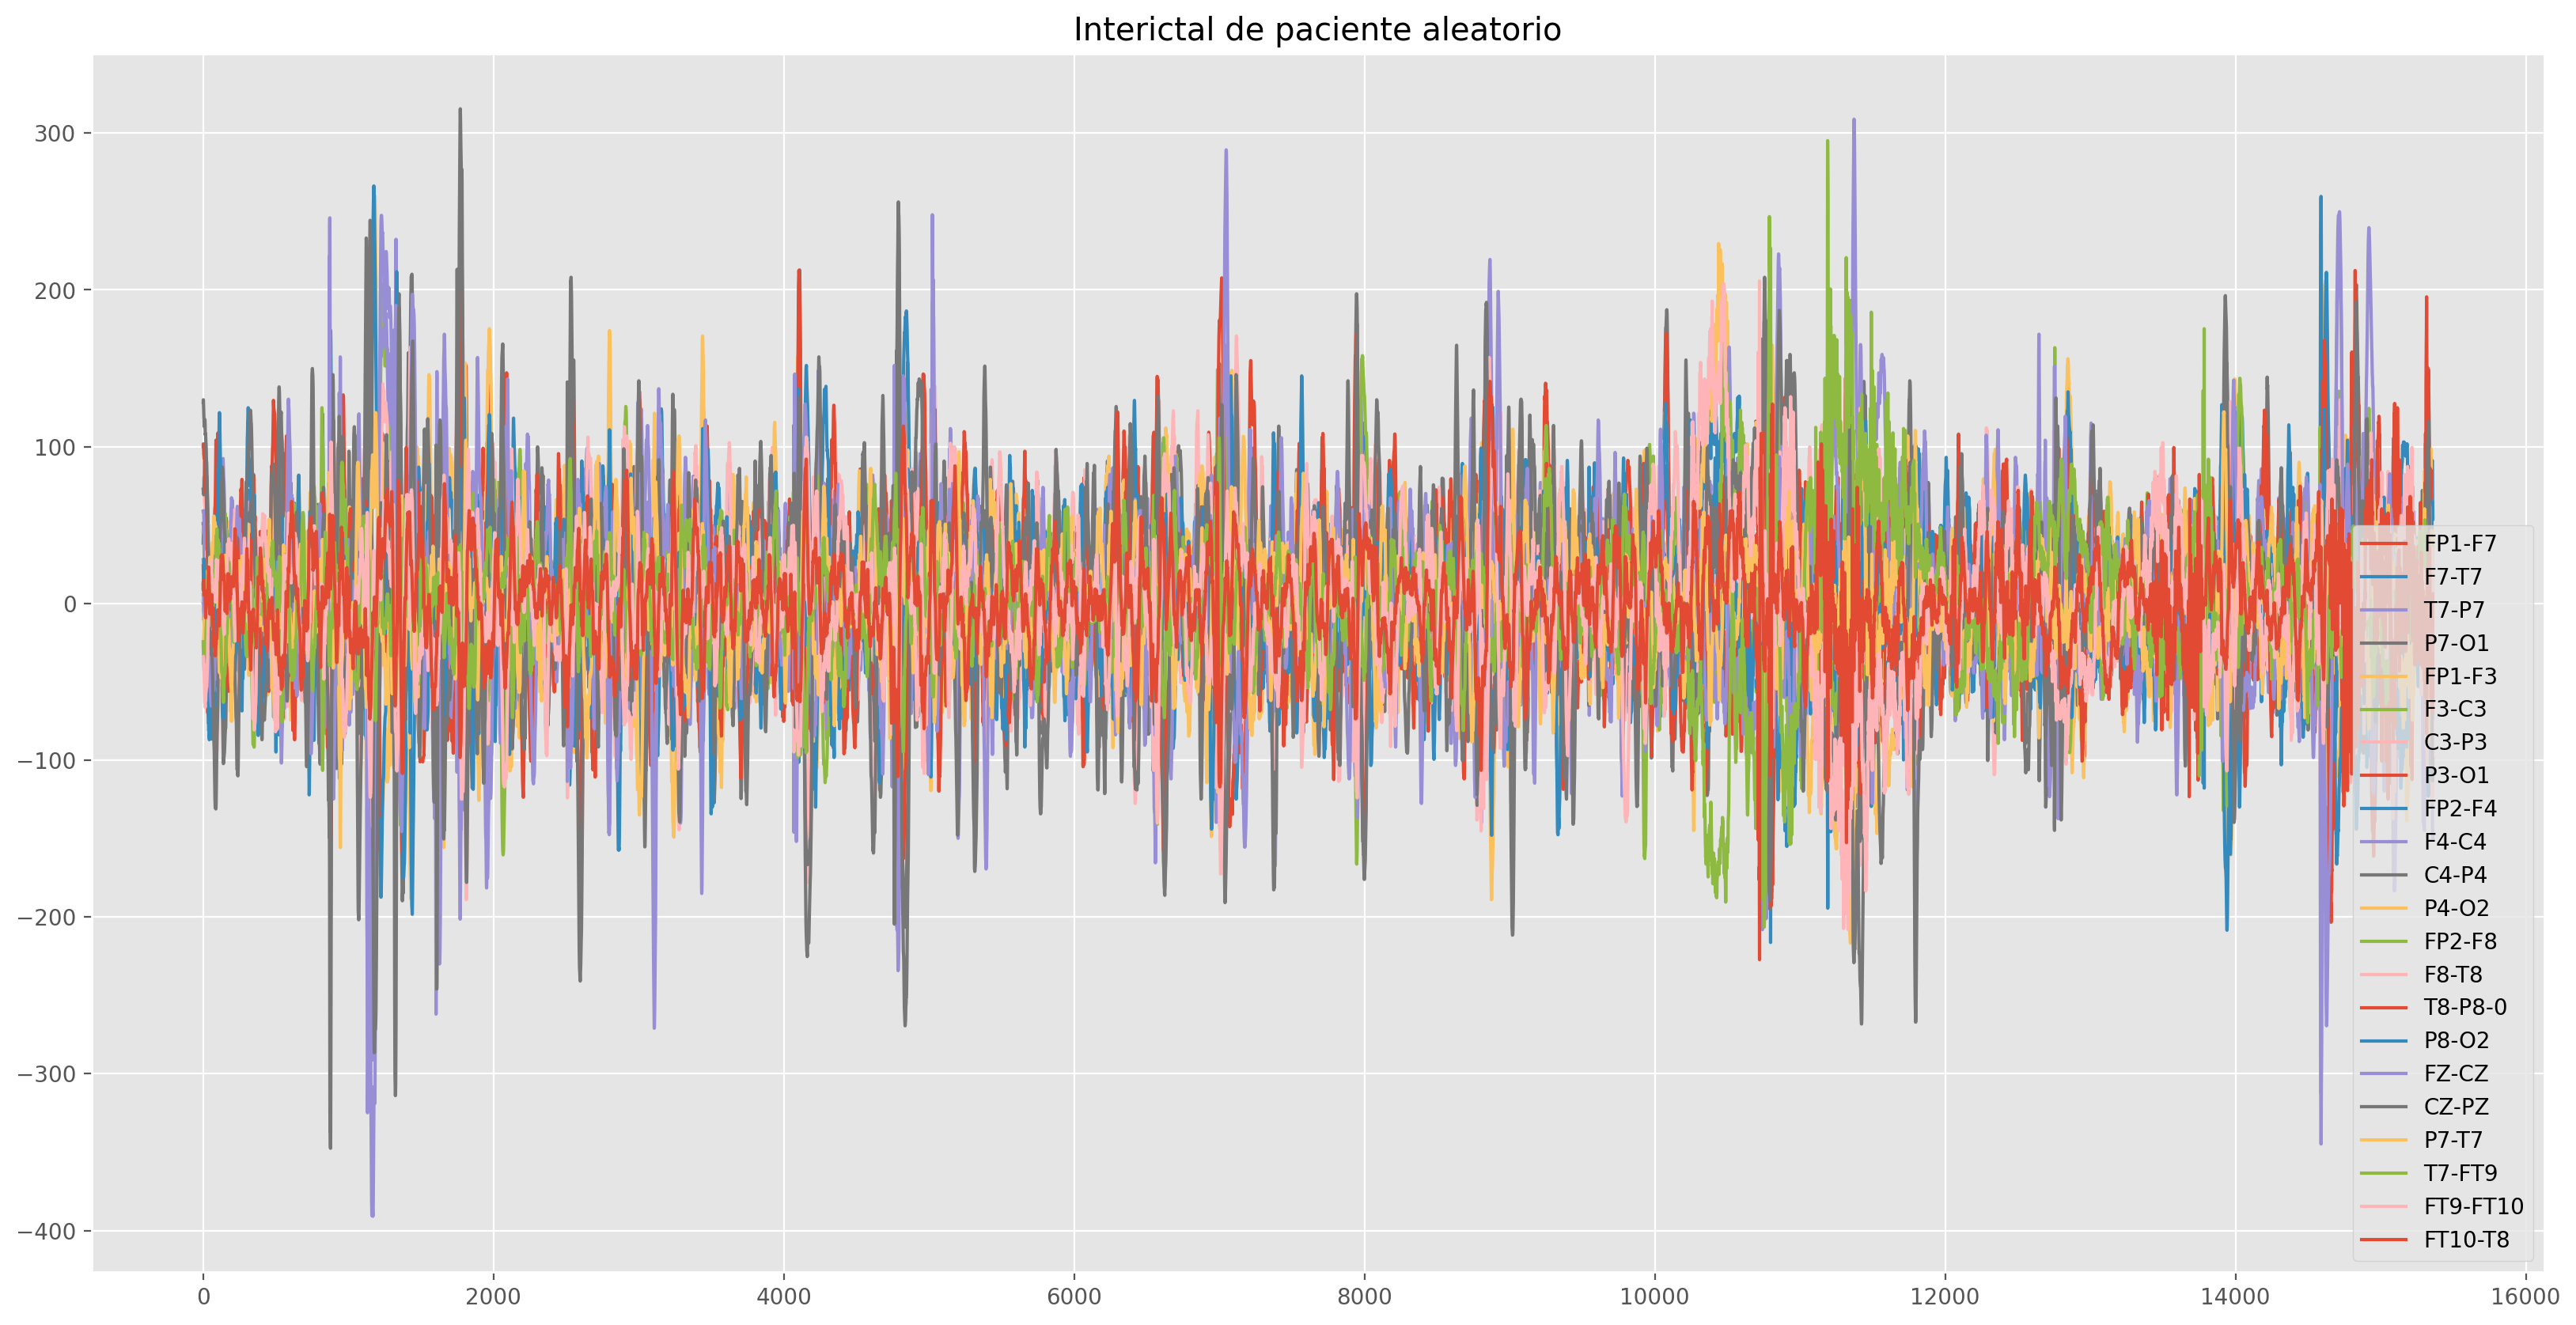

In [7]:
columns = pd.read_parquet(ventanas_path + "/" + train_files[10]).columns
plt.figure(figsize=(20, 10))
plt.plot(X[0])
plt.title("Interictal de paciente aleatorio")
plt.legend(columns)
plt.show()

In [8]:
import warnings

warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

print("Largos (train, test)")
print(len(train_files), len(test_files))

steps = len(y)//BATCH_SIZE

model = create_model_mlp()
nombre_modelo = "mlp"

# model = create_model_cnn1D()
# nombre_modelo = "simple_CNN1D"

# model = create_parallel_cnn1D()
# nombre_modelo = "parallel_CNN1D"

# model = create_model_cnn2D()
# nombre_modelo = "cnn2d"

# model = create_parallel_cnn2D()
# nombre_modelo = "parallel_CNN2D"


my_callback = MyCallback()

start_time = time.time()

history = model.fit(
    X,
    # X_norm,
    y,
    validation_split=0.2,
    epochs=25,
    batch_size=BATCH_SIZE,
    callbacks=[my_callback],
    verbose=2,
)

# Calcula el tiempo de entrenamiento
end_time = time.time()
training_duration = end_time - start_time

Largos (train, test)
1023 255


I0000 00:00:1720944076.258300   30645 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1720944076.355433   30645 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1720944076.355489   30645 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1720944076.357933   30645 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1720944076.357990   30645 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/25


I0000 00:00:1720944091.798039   30738 service.cc:146] XLA service 0x7fea6000b290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720944091.800358   30738 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-07-14 08:01:31.991075: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-14 08:01:32.578447: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
I0000 00:00:1720944095.122769   30738 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-07-14 08:01:42.351189: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 277094400 exceeds 10% of free system memory.
2024-07-14 08:01:52.556180: W external/local_tsl/tsl/framework/bfc_allocator.cc:482] Allocator

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.